## NO2 EDA

### Objectives
- understand data
- compare lanuv and openair no2 measurements (aggregated)
- model to predict no2 measurements (for later)

## Database connection and data retrieval

Credits for API connection and data retrieval:
- https://github.com/ThorbenJensen
- https://github.com/codeformuenster/openair-cologne

In [42]:
### imports

from influxdb import DataFrameClient

import numpy as np
import pandas as pd

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.plotly as py
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [1]:
"""Interactions with influx database."""



def get_db_client() -> DataFrameClient:
    client = DataFrameClient(host='openair.cologne.codefor.de/influx',
                             port=443,
                             database='lanuv')
    return client


def query_influx(query: str) -> dict:
    client = get_db_client()
    result = client.query(query)
    client.close()
    return result

In [2]:
"""Pull data from API and build data frame."""

LAST_N_DAYS = 30

# %% DATA FROM LANUV STATIONS
lanuv_dict = query_influx("SELECT station, NO2 AS no2 "
                          "FROM lanuv_f2 "
                          f"WHERE time >= now() - "f"{LAST_N_DAYS}d "
                          "AND time <= now() ")

# make clean data frame
df_lanuv = lanuv_dict['lanuv_f2'] \
    .rename_axis('timestamp').reset_index()

df_lanuv = df_lanuv[df_lanuv.timestamp.dt.minute == 0]
df_lanuv = df_lanuv[df_lanuv.timestamp.dt.second == 0]

df_lanuv = df_lanuv.assign(
    timestamp=pd.to_datetime(df_lanuv.timestamp.astype(np.int64) // 10 ** 6,
                             unit='ms',
                             utc=True))

# %% DATA FROM OPENAIR
openair_dict = query_influx("SELECT "
                            "median(hum) AS hum, median(pm10) AS pm10, "
                            "median(pm25) AS pm25, median(r1) AS r1, "
                            "median(r2) AS r2, median(rssi) AS rssi, "
                            "median(temp) AS temp "
                            "FROM all_openair "
                            f"WHERE time >= now() - {LAST_N_DAYS}d "
                            "AND time <= now() "
                            "GROUP BY feed, time(1h) fill(-1)")
# clean dictionary keys
openair_dict_clean = {k[1][0][1]: openair_dict[k]
                      for k in openair_dict.keys()}

# initialize empty data frame
df_openair = pd.DataFrame()
# fill data frame with data from all frames
# OPTIONAL: replace for-loop with map-reduce
for feed in list(openair_dict_clean.keys()):
    df_feed = pd.DataFrame.from_dict(openair_dict_clean[feed]) \
        .assign(feed=feed) \
        .rename_axis('timestamp').reset_index()
    df_openair = df_openair.append(df_feed)

# shift timestamp one hour into the future
df_openair_shifted = df_openair \
    .assign(timestamp=lambda d: d.timestamp + pd.Timedelta('1h'))

C:\Users\Alex\Anaconda3\lib\site-packages\urllib3\connectionpool.py:857: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


## Lanuv data

In [11]:
df_lanuv.shape

(2536, 3)

In [12]:
df_lanuv.head()

,timestamp,no2,station
0,2018-12-31 17:00:00+00:00,30,CHOR
1,2018-12-31 17:00:00+00:00,45,VKTU
2,2018-12-31 17:00:00+00:00,36,RODE
3,2018-12-31 17:00:00+00:00,58,VKCL
4,2018-12-31 18:00:00+00:00,35,RODE


In [13]:
df_lanuv['station'].unique()

array(['CHOR', 'VKTU', 'RODE', 'VKCL'], dtype=object)

In [43]:
df_lanuv.describe()

,no2
count,2536.000000
mean,36.292981
std,20.393924
min,5.000000
25%,20.000000
50%,34.000000
75%,49.000000
max,119.000000


### Aggregate lanuv data to daily level

In [ ]:
df_lanuv['date'] = df_lanuv['timestamp'].apply(lambda x: x.date())

In [14]:
df_lanuv_agg_daily = df_lanuv.groupby(by=['station', 'date'], as_index=False).agg({'no2' : ['mean', 'median', 'std', 'min', 'max', lambda x: max(x) - min(x)]})

df_lanuv_agg_daily.columns = ['_'.join(x) for x in df_lanuv_agg_daily.columns.ravel()]
df_lanuv_agg_daily = df_lanuv_agg_daily.rename(columns={'station_' : 'station', 'date_' : 'date', 'no2_<lambda>' : 'no2_max_min_range'})

,station,date,no2_mean,no2_median,no2_std,no2_min,no2_max,no2_max_min_range
0,CHOR,2018-12-31,23.000000,21.0,4.760952,20,30,10
1,CHOR,2019-01-01,6.904762,5.0,3.672938,5,17,12
2,CHOR,2019-01-02,16.952381,10.0,16.695737,5,54,49
3,CHOR,2019-01-03,23.380952,21.0,6.351978,16,40,24
4,CHOR,2019-01-04,21.500000,19.0,7.817867,14,41,27


In [ ]:
df_lanuv_agg_daily.head()

### Visualize raw lanuv data

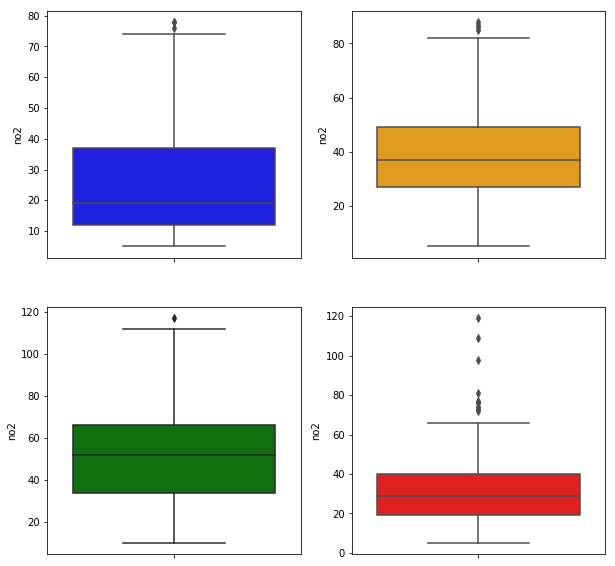

In [17]:
### box plot of hourly no2 measurements for each station in lanuv data

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.boxplot(df_lanuv[df_lanuv['station'] == 'CHOR']['no2'], orient='vertical', color='blue')
plt.subplot(2,2,2)
sns.boxplot(df_lanuv[df_lanuv['station'] == 'VKTU']['no2'], orient='vertical', color='orange')
plt.subplot(2,2,3)
sns.boxplot(df_lanuv[df_lanuv['station'] == 'VKCL']['no2'], orient='vertical', color='green')
plt.subplot(2,2,4)
sns.boxplot(df_lanuv[df_lanuv['station'] == 'RODE']['no2'], orient='vertical', color='red')
plt.show()

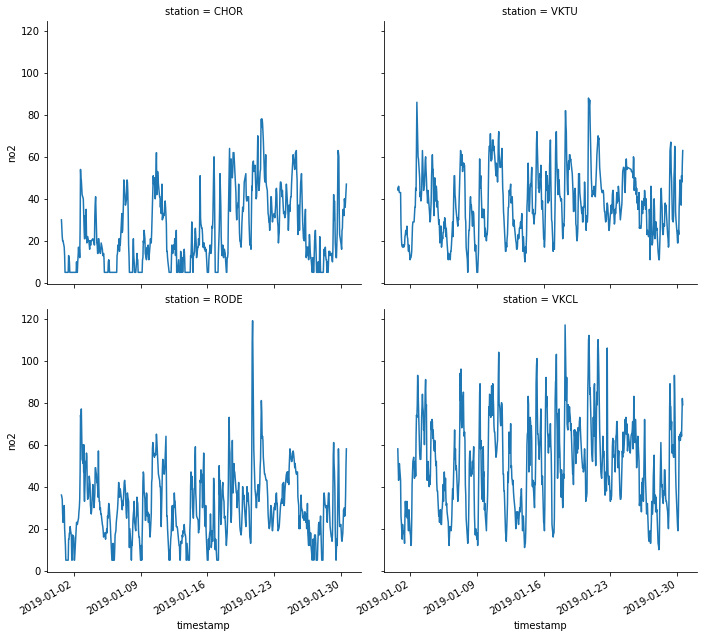

In [18]:
### hourly no2 measurements of lanuv data in the past 30 days (31.12.2018 - 30.01.2019)

g = sns.relplot(x='timestamp', y='no2', kind='line', ci='sd', col='station', markers=True, col_wrap=2, data=df_lanuv)
g.fig.autofmt_xdate()

In [19]:
### interactive hourly no2 measurements of lanuv data in the past 30 days (31.12.2018 - 30.01.2019)

trace0 = go.Scatter(
    x = df_lanuv[df_lanuv['station'] == 'CHOR']['timestamp'],
    y = df_lanuv[df_lanuv['station'] == 'CHOR']['no2'],
    mode = 'lines+markers',
    name = 'lines+markers'
)
trace1 = go.Scatter(
    x = df_lanuv[df_lanuv['station'] == 'VKTU']['timestamp'],
    y = df_lanuv[df_lanuv['station'] == 'VKTU']['no2'],
    mode = 'lines+markers',
    name = 'lines+markers'
)
trace2 = go.Scatter(
    x = df_lanuv[df_lanuv['station'] == 'VKCL']['timestamp'],
    y = df_lanuv[df_lanuv['station'] == 'VKCL']['no2'],
    mode = 'lines+markers',
    name = 'lines+markers'
)
trace3 = go.Scatter(
    x = df_lanuv[df_lanuv['station'] == 'RODE']['timestamp'],
    y = df_lanuv[df_lanuv['station'] == 'RODE']['no2'],
    mode = 'lines+markers',
    name = 'lines+markers'
)
data = [trace0, trace1, trace2, trace3]

figure = go.Figure(data)
iplot(figure)

### Visualize lanuv data aggregated to daily level

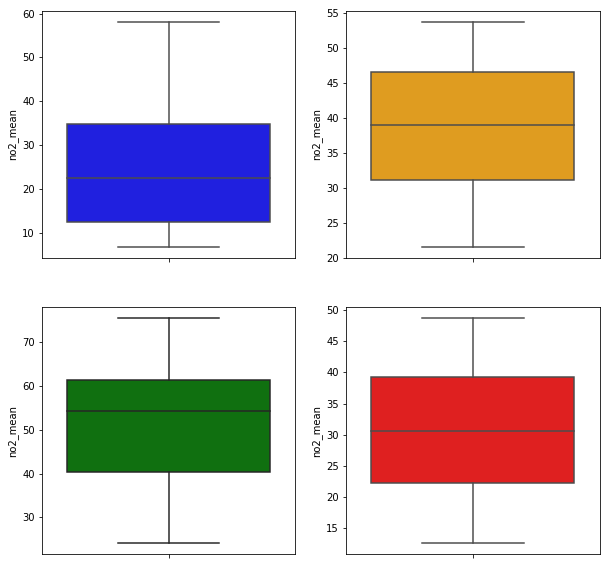

In [21]:
### box plot of daily mean no2 measurements for each station in lanuv data

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
sns.boxplot(df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'CHOR']['no2_mean'], orient='vertical', color='blue')
plt.subplot(2,2,2)
sns.boxplot(df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKTU']['no2_mean'], orient='vertical', color='orange')
plt.subplot(2,2,3)
sns.boxplot(df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKCL']['no2_mean'], orient='vertical', color='green')
plt.subplot(2,2,4)
sns.boxplot(df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'RODE']['no2_mean'], orient='vertical', color='red')
plt.show()

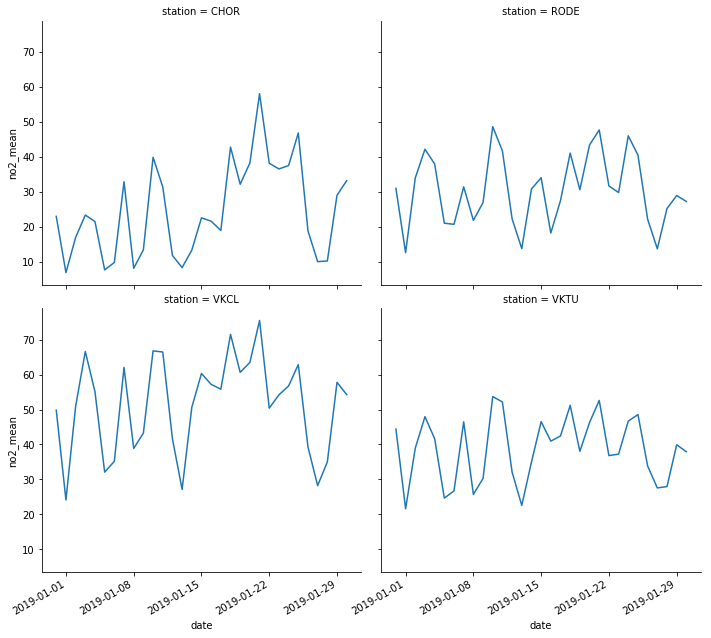

In [24]:
### hourly mean no2 measurements of lanuv data in the past 30 days (31.12.2018 - 30.01.2019)

g = sns.relplot(x='date', y='no2_mean', kind='line', ci='st', col='station', markers=True, col_wrap=2, data=df_lanuv_agg_daily)
g.fig.autofmt_xdate()

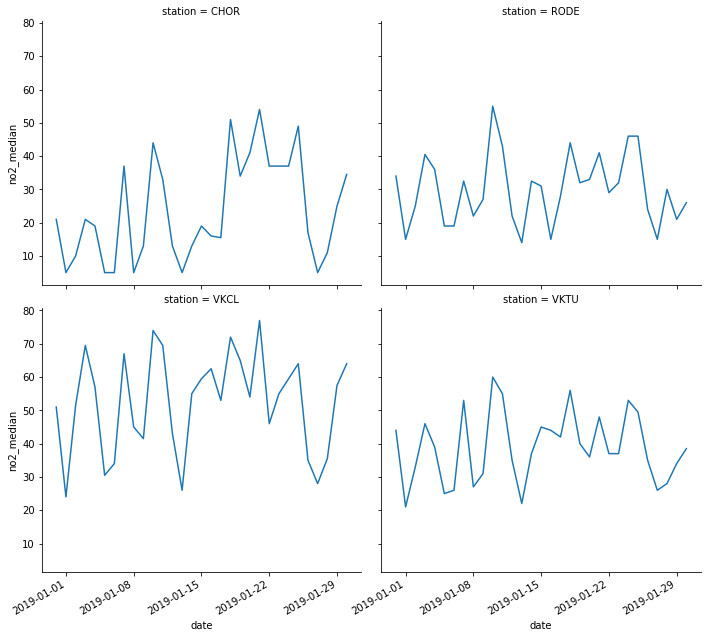

In [27]:
### hourly median no2 measurements of lanuv data in the past 30 days (31.12.2018 - 30.01.2019)

g = sns.relplot(x='date', y='no2_median', kind='line', ci='st', col='station', markers=True, col_wrap=2, data=df_lanuv_agg_daily)
g.fig.autofmt_xdate()

In [25]:
### interactive hourly mean no2 measurements of lanuv data in the past 30 days (31.12.2018 - 30.01.2019)

trace0 = go.Scatter(
    x = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'CHOR']['date'],
    y = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'CHOR']['no2_mean'],
    mode = 'lines+markers',
    name = 'CHOR'
)
trace1 = go.Scatter(
    x = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKTU']['date'],
    y = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKTU']['no2_mean'],
    mode = 'lines+markers',
    name = 'VKTU'
)
trace2 = go.Scatter(
    x = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKCL']['date'],
    y = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKCL']['no2_mean'],
    mode = 'lines+markers',
    name = 'VKCL'
)
trace3 = go.Scatter(
    x = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'RODE']['date'],
    y = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'RODE']['no2_mean'],
    mode = 'lines+markers',
    name = 'RODE'
)
data = [trace0, trace1, trace2, trace3]

figure = go.Figure(data)
iplot(figure)

In [26]:
### interactive hourly median no2 measurements of lanuv data in the past 30 days (31.12.2018 - 30.01.2019)

trace0 = go.Scatter(
    x = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'CHOR']['date'],
    y = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'CHOR']['no2_median'],
    mode = 'lines+markers',
    name = 'CHOR'
)
trace1 = go.Scatter(
    x = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKTU']['date'],
    y = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKTU']['no2_median'],
    mode = 'lines+markers',
    name = 'VKTU'
)
trace2 = go.Scatter(
    x = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKCL']['date'],
    y = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'VKCL']['no2_median'],
    mode = 'lines+markers',
    name = 'VKCL'
)
trace3 = go.Scatter(
    x = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'RODE']['date'],
    y = df_lanuv_agg_daily[df_lanuv_agg_daily['station'] == 'RODE']['no2_median'],
    mode = 'lines+markers',
    name = 'RODE'
)
data = [trace0, trace1, trace2, trace3]

figure = go.Figure(data)
iplot(figure)

## Openair data

#### columns
- feed = sensoren (20 stück, es gibt blacklist)
- hum = humidity (wichtig)
- pm10 = feinstaub (unwichtig)
- pm25 = feinstaub (unwichtig)
- r1 = no2 (kohlenmonoxid sensor) (unwichtig, zu fehleranfällig)
- r2 = no2 (proxy, analogwert) (wichtig)
- rssi = empfangsstärke zum heimnetzwerk
- temp = temperatur (wichtig)


#### todo
- n02 grenzwert = 40
- aggregationen no2 werte (bspw. 4-5 h. openair misst alle 15 min, lanuv jede stunde)
- korrelation mit lanuv daten überprüfen
- api zur inversionswetterlage

#### model
- input: hum, r2, temp
- zielwert: lanuv 4h mittelwerte, für jeden sensor eigenes modell (Marcel: VKTU, VKCL, CHOR -> RODE in der pampa)
- neues feature: distanz zu offiziellen messtationen

In [29]:
df_openair.shape

(13699, 9)

In [30]:
df_openair.head()

,timestamp,hum,pm10,pm25,r1,r2,rssi,temp,feed
0,2018-12-31 16:00:00+00:00,47.390,0,0,0.0,1800.0,-52.0,14.840,807f153a-d0f6-11e7-b63b-001999f98771
1,2018-12-31 17:00:00+00:00,47.480,0,0,9.0,1807.5,-52.0,14.690,807f153a-d0f6-11e7-b63b-001999f98771
2,2018-12-31 18:00:00+00:00,47.360,0,0,18.0,1822.0,-51.0,14.615,807f153a-d0f6-11e7-b63b-001999f98771
3,2018-12-31 19:00:00+00:00,47.360,0,0,0.0,1802.0,-53.0,14.350,807f153a-d0f6-11e7-b63b-001999f98771
4,2018-12-31 20:00:00+00:00,46.395,0,0,0.0,1780.0,-52.0,14.410,807f153a-d0f6-11e7-b63b-001999f98771


In [38]:
df_openair['feed'].nunique()

19

In [36]:
# drop columns that are not of primary importance for now
df_openair.drop(['pm10', 'pm25', 'r1', 'rssi'], axis=1, inplace=True)

In [35]:
df_openair.head()

,timestamp,hum,r2,temp,feed
0,2018-12-31 16:00:00+00:00,47.390,1800.0,14.840,807f153a-d0f6-11e7-b63b-001999f98771
1,2018-12-31 17:00:00+00:00,47.480,1807.5,14.690,807f153a-d0f6-11e7-b63b-001999f98771
2,2018-12-31 18:00:00+00:00,47.360,1822.0,14.615,807f153a-d0f6-11e7-b63b-001999f98771
3,2018-12-31 19:00:00+00:00,47.360,1802.0,14.350,807f153a-d0f6-11e7-b63b-001999f98771
4,2018-12-31 20:00:00+00:00,46.395,1780.0,14.410,807f153a-d0f6-11e7-b63b-001999f98771


In [40]:
df_openair.describe()

,hum,r2,temp
count,13699.000000,13699.000000,13699.000000
mean,31.709123,920.579860,11.866555
std,66.334145,786.268444,83.291331
min,-5.265000,-1.000000,-3.550000
25%,-1.000000,-1.000000,-1.000000
50%,28.565000,1289.000000,4.860000
75%,46.275000,1620.500000,9.230000
max,749.430000,2635.500000,1008.110000


### Aggregate openair data to daily level

In [44]:
df_openair['date'] = df_openair['timestamp'].apply(lambda x: x.date())

In [45]:
### TBD

### Visualize raw openair data

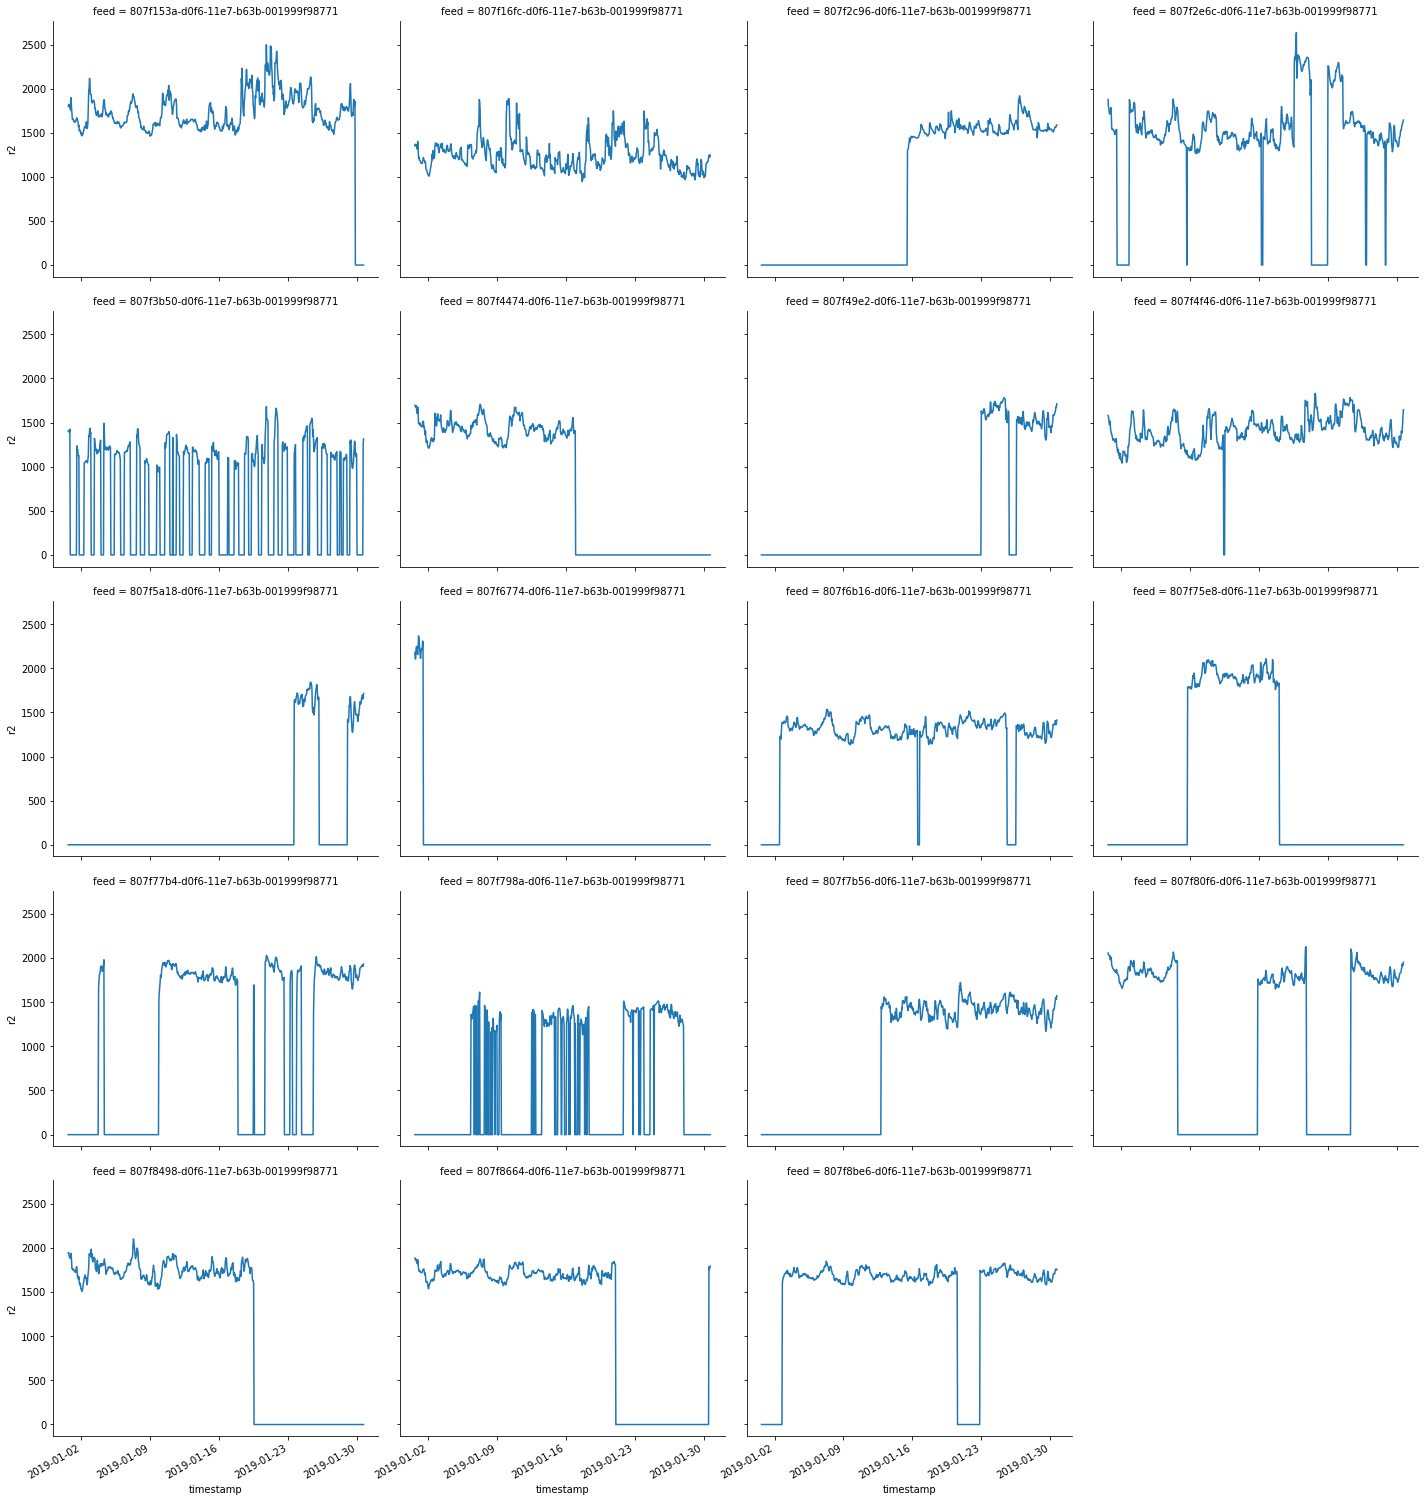

In [41]:
g = sns.relplot(x='timestamp', y='r2', kind='line', ci='sd', col='feed', markers=True, col_wrap=4, data=df_openair)
g.fig.autofmt_xdate()

### Visualize openair data  aggregated to daily level

## Merge openair and lanuv data

In [ ]:
#df_lanuv_openair_agg = df_lanuv_agg3.merge(feed_agg, on='date', how='left')

In [ ]:
#df_lanuv_openair_agg.head(100)

In [ ]:
#corr = df_lanuv_openair_agg.loc[:, ('no2_mean','hum', 'r2', 'temp')].corr()
#sns.heatmap(corr, annot=True)